In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import train
import network_unet as unet
import network_hed as hed
import torch

#reimport
import evaluation as eval
import importlib
importlib.reload(eval)

import utils
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/utils.py'>

In [43]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets[0]))
print(np.shape(test_input[0]))

# Points dictionary
points_dict = np.load('../data/SIVE/points_dict.npy', allow_pickle=True).item()


Test dimensions:
(750, 650)
(5, 750, 650)


In [54]:
model_file = "../models/SIVE_04JUN2025/"
model_paths = glob.glob(model_file + '*.pth')
print("Model files found:")
print(model_paths)

Model files found:
['../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_wBCE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_DICE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_ImageNet_trainable_unguided_wBCE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_ImageNet_frozen_guided_wBCE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_DICE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_wBCE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_DICE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_ImageNet_trainable_unguided_DICE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_SimpleCNN_trainable_guided_DICE.pth', '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_SimpleCNN_trai

In [45]:


model_path = '../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth'
model, meta_data = utils.get_model(model_path)

print("Model metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

Loading model: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Model metadata:
name: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
date: 04JUN2025
arcitecture: HED
backbone: BigEarthNet
freeze_backbone: trainable
guidance: True
loss_function: wBCE


Processing file: 20171129T113419_portmarnock
Image shape: (6, 1000, 800)
Number of crops: 10


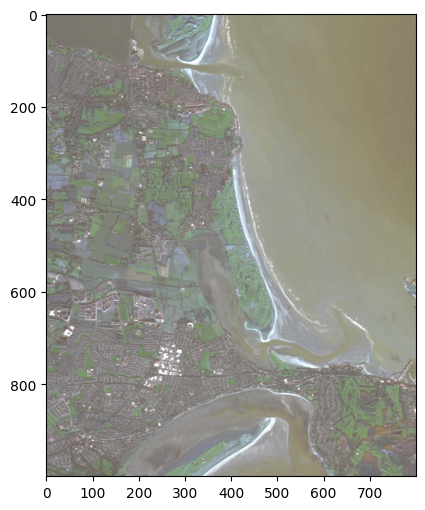

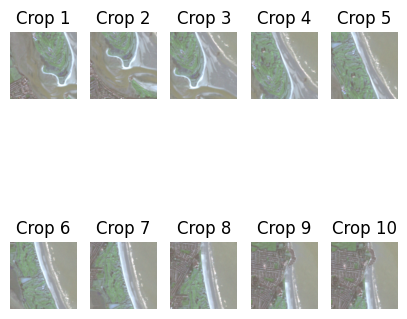

In [46]:


path = test_paths[1]
ID = os.path.basename(path).split('.')[0]
print(f"Processing file: {ID}")
image = np.load(path)
print(f"Image shape: {image.shape}")
points = points_dict[ID]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

rgb_image = utils.get_rgb(image,contrast=0.3)
ax.imshow(rgb_image)

crop_paths, start_points = utils.get_iterative_crops(image, points)
print(f"Number of crops: {len(crop_paths)}")

fig,ax = plt.subplots(2, 5, figsize=(5, 5))
ax = ax.flatten()
for i, crop in enumerate(crop_paths):
    crop = np.load(crop)
    rgb_crop = utils.get_rgb(crop, contrast=0.3)
    ax[i].imshow(rgb_crop)
    ax[i].set_title(f"Crop {i+1}",)
    ax[i].axis('off')

Text(0.5, 1.0, 'Prediction')

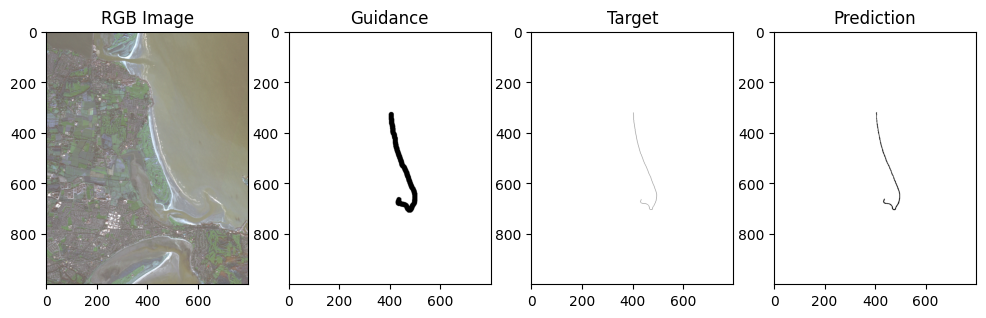

In [47]:
crop_paths, start_points = utils.get_iterative_crops(image, points)

crop_targets, crop_preds = eval.get_preds(model,meta_data["guidance"],crop_paths,batch_size=1)

combined_pred = utils.combine_crops(crop_preds, start_points, image)

fig, ax = plt.subplots(1, 4, figsize=(12, 6))
ax[0].imshow(rgb_image)
ax[0].set_title("RGB Image")

ax[1].imshow(1-image[-2], cmap='gray')
ax[1].set_title("Guidance")

ax[2].imshow(1-image[-1], cmap='gray')
ax[2].set_title("Target")

ax[3].imshow(1-combined_pred, cmap='gray')
ax[3].set_title("Prediction")

Text(0.5, 1.0, 'Post-processed Prediction')

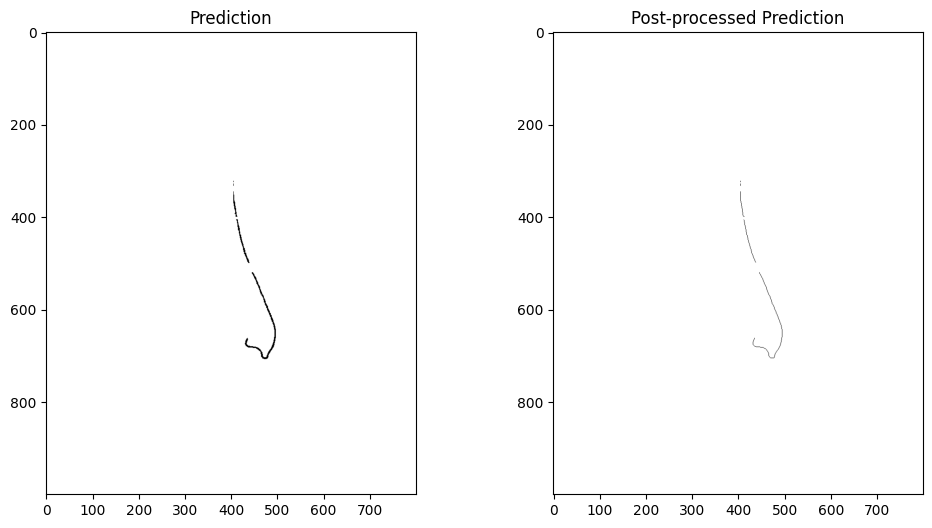

In [48]:

   

pred_full_alt = combined_pred.copy()
pred_full_alt[400:405,:] = 0 
pred_full_alt[500:520,:] = 0
pred_full_alt[:,400:405] = 0  # Simulate a gap in the edge map for testing

processed_pred_full = utils.thin_edge_map(pred_full_alt)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(1-pred_full_alt, cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(1-processed_pred_full, cmap='gray')
ax[1].set_title("Post-processed Prediction")

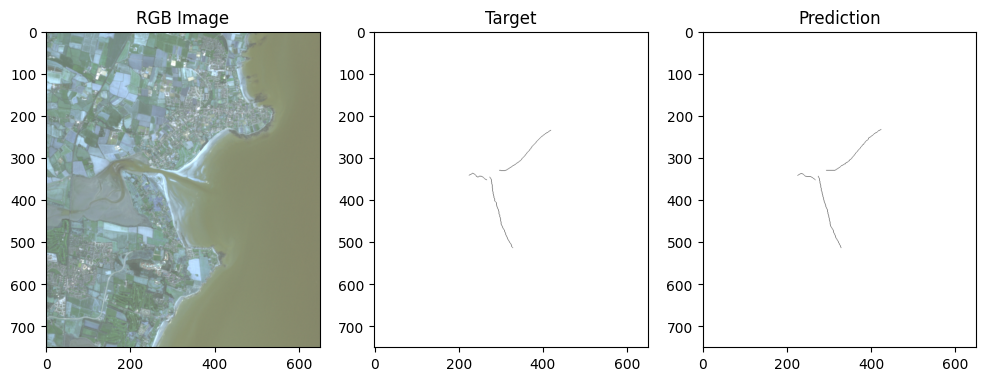

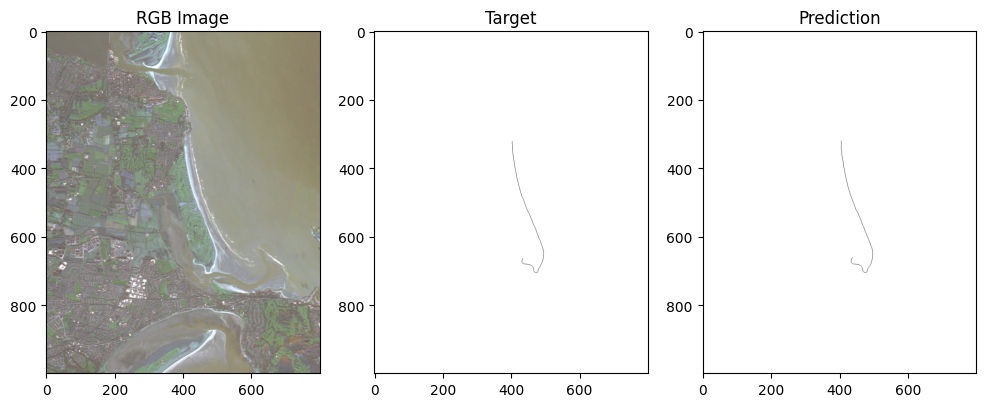

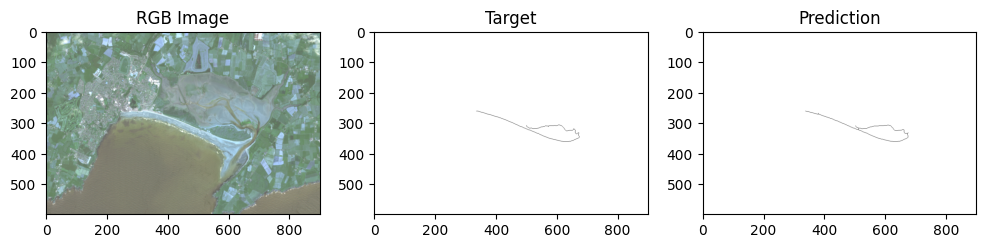

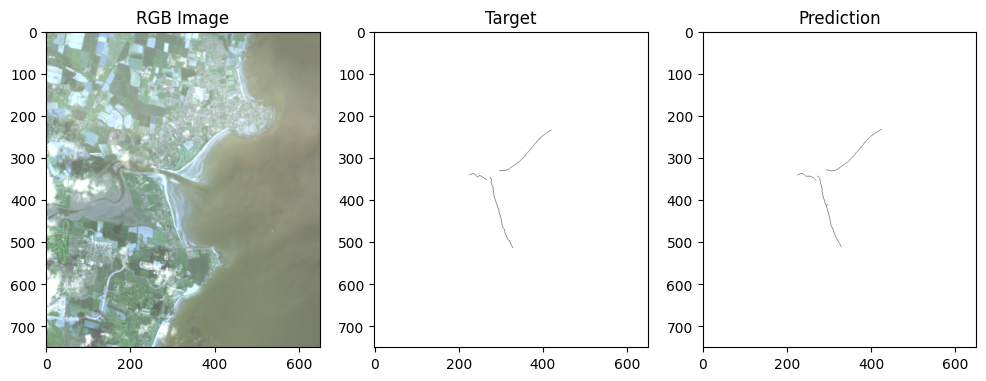

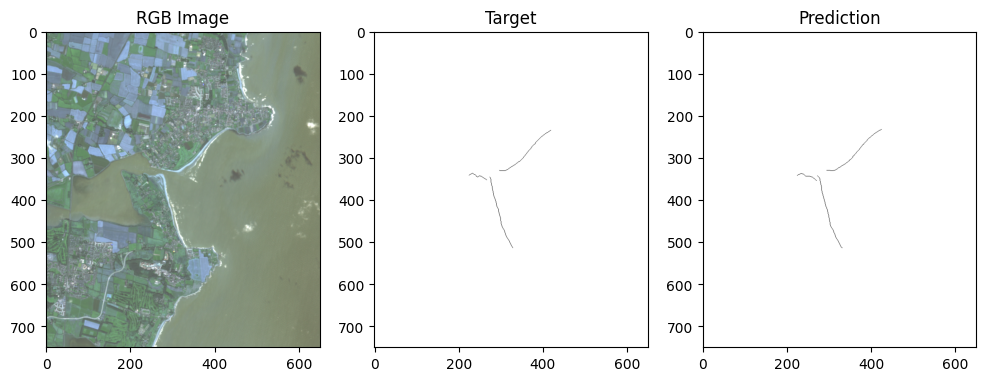

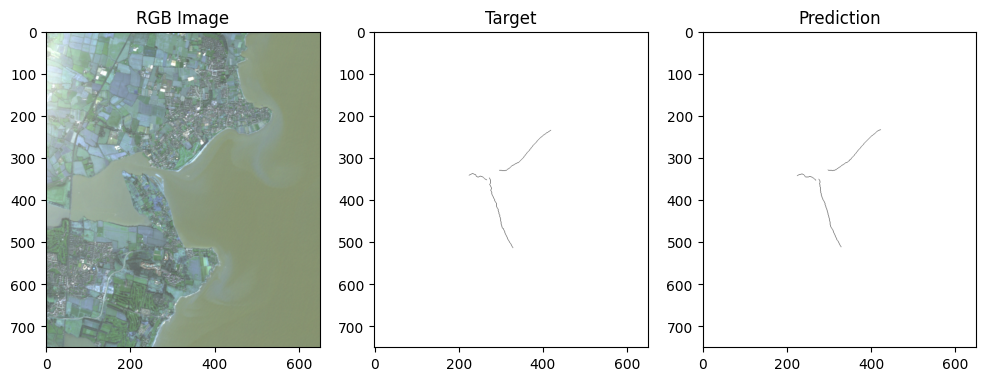

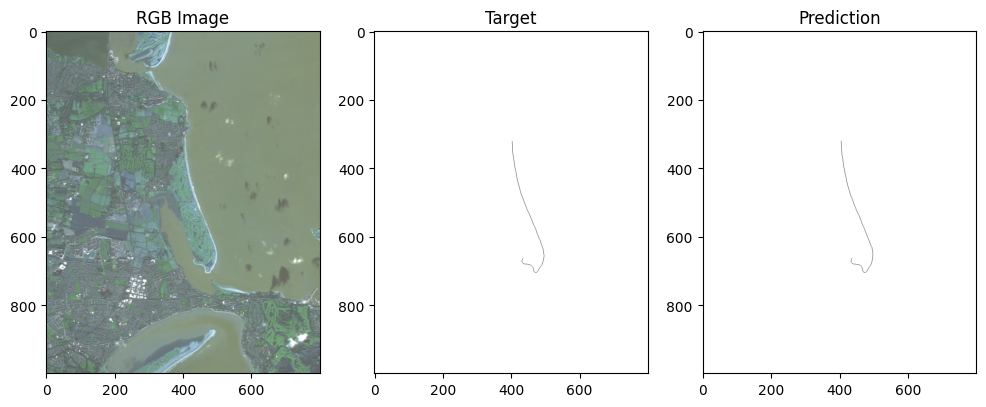

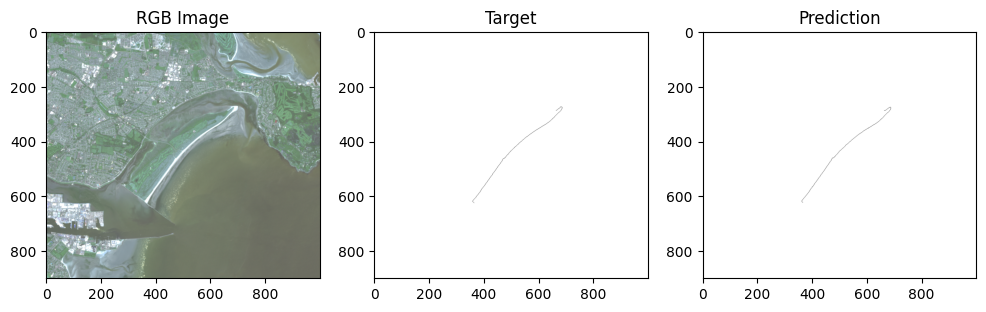

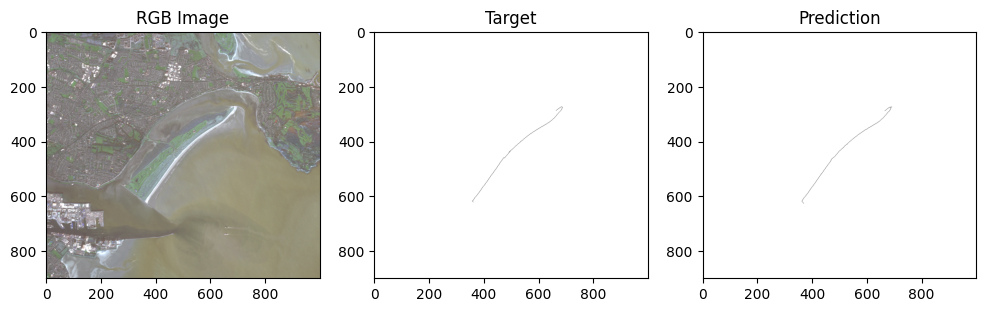

In [49]:
targets = []
preds = []

for path in test_paths:
    image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

    targets.append(image[-1])
    preds.append(pred_full)

    ID = os.path.basename(path).split('.')[0]
    points = points_dict[ID][1]

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    rgb_image = utils.get_rgb(image, contrast=0.3)
    ax[0].imshow(rgb_image)
    ax[0].set_title("RGB Image")
    
    ax[1].imshow(1-image[-1], cmap='gray')
    ax[1].set_title("Target")

    ax[2].imshow(1-pred_full, cmap='gray')
    ax[2].set_title("Prediction")
    
    plt.show()

In [55]:
test_metrics, test_arr = eval.eval_metrics(targets, preds)
print("Test Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test Metrics:
accuracy: 0.9995
precision: 0.6105
recall: 0.6200
f1: 0.6152
iou: 0.4475
fom: 0.9528


In [58]:
def get_all_results(model_paths, test_paths,points_dict):
    results = []
    for model_path in model_paths:
        print(f"Processing model: {model_path}")

        model, meta_data = utils.get_model(model_path)
        
        targets = []
        preds = []

        for path in test_paths:
            image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

            targets.append(image[-1])
            preds.append(pred_full)

        test_metrics, test_arr = eval.eval_metrics(targets, preds)

        row = meta_data | test_metrics
        results.append(row)
        
    return results

In [60]:
#reimport utils
import utils
importlib.reload(utils)

results = get_all_results(model_paths[0:5], test_paths,points_dict)
results_df = pd.DataFrame(results)
results_df

Processing model: ../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE.pth
Loading model: SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE.pth
Model name split: ['SIVE', '04JUN2025', 'HED', 'ImageNet', 'frozen', 'guided', 'DICE.pth']

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_wBCE.pth
Loading model: SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided_wBCE.pth
Model name split: ['SIVE', '04JUN2025', 'HED', 'BigEarthNet', 'frozen', 'unguided', 'wBCE.pth']

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_04JUN2025/SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_DICE.pth
Loading model: SIVE_04JUN2025_HED_BigEarthNet_trainable_unguided_DICE.pth
Model name split: ['SIVE', '04JUN2025', 'HED', 'BigEarthNet', 'trainable', 'unguided', 'DICE.pth']

,name,date,arcitecture,backbone,freeze_backbone,guidance,loss_function,accuracy,precision,recall,f1,iou,fom
0,SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE...,04JUN2025,HED,ImageNet,frozen,True,DICE,0.999481,0.603185,0.576199,0.589154,0.420627,0.906959
1,SIVE_04JUN2025_HED_BigEarthNet_frozen_unguided...,04JUN2025,HED,BigEarthNet,frozen,False,wBCE,0.998624,0.247381,0.452015,0.313156,0.188798,0.547176
2,SIVE_04JUN2025_HED_BigEarthNet_trainable_ungui...,04JUN2025,HED,BigEarthNet,trainable,False,DICE,0.999458,0.583718,0.564415,0.573537,0.404725,0.897991
3,SIVE_04JUN2025_HED_ImageNet_trainable_unguided...,04JUN2025,HED,ImageNet,trainable,False,wBCE,0.999403,0.544666,0.600394,0.570396,0.402899,0.882895
4,SIVE_04JUN2025_HED_BigEarthNet_trainable_guide...,04JUN2025,HED,BigEarthNet,trainable,True,wBCE,0.999491,0.610528,0.620035,0.615189,0.447490,0.952775


In [17]:
results_df.sort_values(by=['backbone','freeze_backbone','loss_function','guidance',], ascending=False).drop(columns=['name', 'date','arcitecture'])

,backbone,freeze_backbone,guidance,loss_function,accuracy,precision,recall,f1,iou,fom
15,SimpleCNN,trainable,True,wBCE,0.999630,0.549235,0.532001,0.540176,0.386425,0.902181
11,SimpleCNN,trainable,False,wBCE,0.999463,0.358329,0.402559,0.375474,0.238331,0.599963
10,SimpleCNN,trainable,True,DICE,0.999662,0.606989,0.485402,0.538560,0.381265,0.749504
16,SimpleCNN,trainable,False,DICE,0.999582,0.489013,0.384945,0.418500,0.274024,0.554945
17,ImageNet,trainable,True,wBCE,0.999579,0.487980,0.470572,0.478789,0.325905,0.892108
3,ImageNet,trainable,False,wBCE,0.999407,0.294690,0.318510,0.304460,0.186091,0.576469
13,ImageNet,trainable,True,DICE,0.999659,0.593273,0.508747,0.546783,0.388059,0.805141
9,ImageNet,trainable,False,DICE,0.999521,0.408697,0.345126,0.368511,0.231308,0.553758
5,ImageNet,frozen,True,wBCE,0.999323,0.225169,0.262054,0.241997,0.142997,0.816916
14,ImageNet,frozen,False,wBCE,0.999063,0.179152,0.356454,0.237578,0.139915,0.444403


In [15]:
results_df.sort_values(by=['fom'], ascending=False).drop(columns=[ 'date','arcitecture'])


,name,backbone,freeze_backbone,guidance,loss_function,accuracy,precision,recall,f1,iou,fom
4,SIVE_04JUN2025_HED_BigEarthNet_trainable_guide...,BigEarthNet,trainable,True,wBCE,0.999616,0.535284,0.523864,0.529328,0.369035,0.917637
15,SIVE_04JUN2025_HED_SimpleCNN_trainable_guided_...,SimpleCNN,trainable,True,wBCE,0.999630,0.549235,0.532001,0.540176,0.386425,0.902181
17,SIVE_04JUN2025_HED_ImageNet_trainable_guided_w...,ImageNet,trainable,True,wBCE,0.999579,0.487980,0.470572,0.478789,0.325905,0.892108
5,SIVE_04JUN2025_HED_ImageNet_frozen_guided_wBCE...,ImageNet,frozen,True,wBCE,0.999323,0.225169,0.262054,0.241997,0.142997,0.816916
18,SIVE_04JUN2025_HED_BigEarthNet_frozen_guided_w...,BigEarthNet,frozen,True,wBCE,0.999351,0.254415,0.286863,0.269459,0.165600,0.815305
13,SIVE_04JUN2025_HED_ImageNet_trainable_guided_D...,ImageNet,trainable,True,DICE,0.999659,0.593273,0.508747,0.546783,0.388059,0.805141
8,SIVE_04JUN2025_HED_BigEarthNet_trainable_guide...,BigEarthNet,trainable,True,DICE,0.999656,0.599497,0.487247,0.536577,0.381478,0.769447
0,SIVE_04JUN2025_HED_ImageNet_frozen_guided_DICE...,ImageNet,frozen,True,DICE,0.999603,0.517850,0.427837,0.467183,0.314840,0.769409
10,SIVE_04JUN2025_HED_SimpleCNN_trainable_guided_...,SimpleCNN,trainable,True,DICE,0.999662,0.606989,0.485402,0.538560,0.381265,0.749504
12,SIVE_04JUN2025_HED_BigEarthNet_frozen_guided_D...,BigEarthNet,frozen,True,DICE,0.999623,0.547120,0.418899,0.473058,0.320034,0.706476


# Evaluation with image crops

In [16]:
# Test data
target_pos = 4

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets))
print(np.shape(test_input))

Test dimensions:


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.

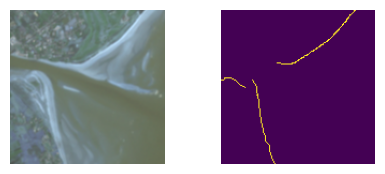

In [ ]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

fig, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

In [ ]:
model_file = "../models/SIVE_02JUN2025/"
model_paths = glob.glob(model_file + '*.pth')
print("Model files found:")
print(model_paths)

Model files found:
['../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_DICE.pth']


In [ ]:
# Helper functions 



def get_all_results(model_paths, test_paths):
    results = []
    for model_path in model_paths:
        model, meta_data = get_model(model_path)

        targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
        test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)

        row = meta_data | test_metrics
        results.append(row)
        
    return results

In [ ]:
results = get_all_results(model_paths, test_paths)
results_df = pd.DataFrame(results)

Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth
Side channels: [64, 128, 256, 512, 512]

Loading model: SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth
Side channels: [64, 128, 256, 512, 512]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:166: RuntimeWarning: invalid value encountered in scalar divide
  iou = TP_ / (TP_ + FP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:119: RuntimeWarning: invalid value encountered in scalar divide
  fom /= np.maximum(np.count_nonzero(img), np.count_nonzero(ref_img))


Loading model: SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_ImageNet_False_DICE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:166: RuntimeWarning: invalid value encountered in scalar divide
  iou = TP_ / (TP_ + FP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:119: RuntimeWarning: invalid value encountered

Loading model: SIVE_02JUN2025_HED_ImageNet_True_DICE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


In [ ]:
results_df.drop(columns=['name','date']).sort_values(by=['arcitecture','backbone','freeze_backbone','loss_function'], ascending=False)

,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
3,HED,SimpleCNN,False,wBCE.pth,0.984806,0.307887,0.990375,0.466723,0.307081,0.853162
6,HED,SimpleCNN,False,DICE.pth,0.993144,0.000000,0.000000,0.000000,0.000000,0.000000
5,HED,ImageNet,True,wBCE.pth,0.968758,0.184361,0.991124,0.306631,0.184217,0.681837
9,HED,ImageNet,True,DICE.pth,0.992473,0.465307,0.765488,0.570354,0.409208,0.861617
4,HED,ImageNet,False,wBCE.pth,0.981103,0.263218,0.990438,0.413578,0.262665,0.836403
8,HED,ImageNet,False,DICE.pth,0.994374,0.556914,0.721830,0.617732,0.461763,0.885567
7,HED,BigEarthNet,True,wBCE.pth,0.950335,0.132046,0.996678,0.229087,0.132020,0.564425
2,HED,BigEarthNet,True,DICE.pth,0.993480,0.508890,0.733757,0.593552,0.434286,0.866708
1,HED,BigEarthNet,False,wBCE.pth,0.984539,0.304583,0.982190,0.462294,0.302716,0.867830
0,HED,BigEarthNet,False,DICE.pth,0.994436,0.565645,0.720104,0.622551,0.463816,0.898835


In [ ]:
best_models = results_df.drop(columns=['date']).sort_values(by=['fom'], ascending=False)
best_models

,name,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
0,SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth,HED,BigEarthNet,False,DICE.pth,0.994436,0.565645,0.720104,0.622551,0.463816,0.898835
8,SIVE_02JUN2025_HED_ImageNet_False_DICE.pth,HED,ImageNet,False,DICE.pth,0.994374,0.556914,0.721830,0.617732,0.461763,0.885567
1,SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth,HED,BigEarthNet,False,wBCE.pth,0.984539,0.304583,0.982190,0.462294,0.302716,0.867830
2,SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth,HED,BigEarthNet,True,DICE.pth,0.993480,0.508890,0.733757,0.593552,0.434286,0.866708
9,SIVE_02JUN2025_HED_ImageNet_True_DICE.pth,HED,ImageNet,True,DICE.pth,0.992473,0.465307,0.765488,0.570354,0.409208,0.861617
3,SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth,HED,SimpleCNN,False,wBCE.pth,0.984806,0.307887,0.990375,0.466723,0.307081,0.853162
4,SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth,HED,ImageNet,False,wBCE.pth,0.981103,0.263218,0.990438,0.413578,0.262665,0.836403
5,SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth,HED,ImageNet,True,wBCE.pth,0.968758,0.184361,0.991124,0.306631,0.184217,0.681837
7,SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth,HED,BigEarthNet,True,wBCE.pth,0.950335,0.132046,0.996678,0.229087,0.132020,0.564425
6,SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth,HED,SimpleCNN,False,DICE.pth,0.993144,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
best_models = results_df.drop(columns=['date']).sort_values(by=['fom'], ascending=False)
best_models

,name,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
0,SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth,HED,BigEarthNet,False,DICE.pth,0.994436,0.565645,0.720104,0.622551,NaN,0.898835
8,SIVE_02JUN2025_HED_ImageNet_False_DICE.pth,HED,ImageNet,False,DICE.pth,0.994374,0.556914,0.721830,0.617732,NaN,0.885567
1,SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth,HED,BigEarthNet,False,wBCE.pth,0.984539,0.304583,0.982190,0.462294,NaN,0.867830
2,SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth,HED,BigEarthNet,True,DICE.pth,0.993480,0.508890,0.733757,0.593552,NaN,0.866708
9,SIVE_02JUN2025_HED_ImageNet_True_DICE.pth,HED,ImageNet,True,DICE.pth,0.992473,0.465307,0.765488,0.570354,NaN,0.861617
3,SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth,HED,SimpleCNN,False,wBCE.pth,0.984806,0.307887,0.990375,0.466723,NaN,0.853162
4,SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth,HED,ImageNet,False,wBCE.pth,0.981103,0.263218,0.990438,0.413578,NaN,0.836403
5,SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth,HED,ImageNet,True,wBCE.pth,0.968758,0.184361,0.991124,0.306631,NaN,0.681837
7,SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth,HED,BigEarthNet,True,wBCE.pth,0.950335,0.132046,0.996678,0.229087,NaN,0.564425
6,SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth,HED,SimpleCNN,False,DICE.pth,0.993144,0.000000,0.000000,0.000000,NaN,0.000000


Best model: SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth
Loading model: SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

848


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)


accuracy: 98.5098
precision: 22.6155
recall: 70.3413
f1: 32.2352
iou: nan
fom: 65.4215


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


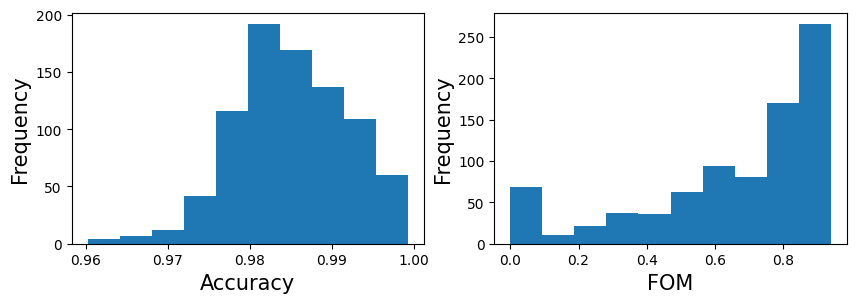

In [ ]:
best_model_name = best_models.iloc[0]['name']
print(f"Best model: {best_model_name}")
best_model_path = os.path.join(model_file, best_model_name)
model, meta_data = get_model(best_model_path)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)


[0. 1.]


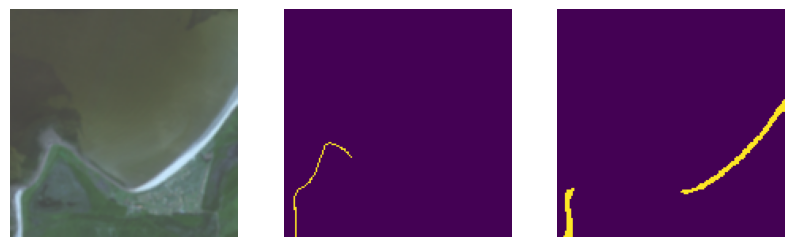

In [ ]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Model metadata:
{'name': 'SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth', 'date': '02JUN2025', 'model_type': 'HED', 'backbone': ResNet50Backbone(
  (backbone): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Module(
      (0): Module(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


accuracy: 99.4436
precision: 56.5645
recall: 72.0104
f1: 62.2551
iou: nan
fom: 89.8835


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


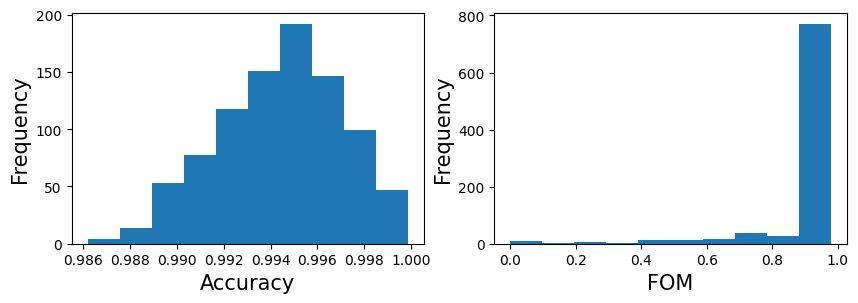

In [ ]:
model_path = model_paths[0]  # Use the first model found
model, meta_data = get_model(model_path)
print("Model metadata:")
print(meta_data)


targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))
test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)

accuracy: 99.4436
precision: 56.5645
recall: 72.0104
f1: 62.2551
iou: nan
fom: 89.8835


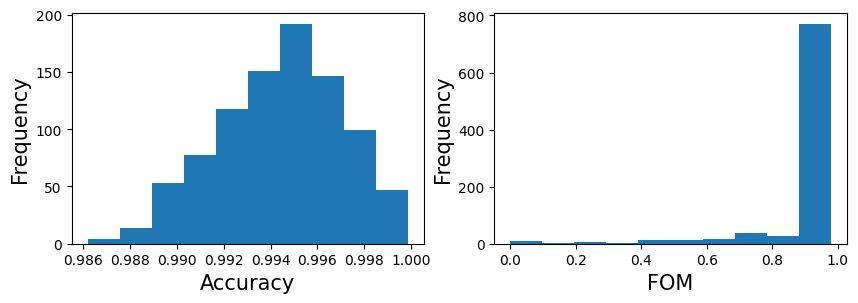

In [ ]:
eval.display_metrics(test_metrics, test_arr)

# HED ImageNet

Using device: mps


Side channels: [16, 24, 80, 112, 320]
196


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)


accuracy: 91.079
precision: 5.7618
recall: 92.5089
f1: 10.8272
iou: nan
fom: 44.8264


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


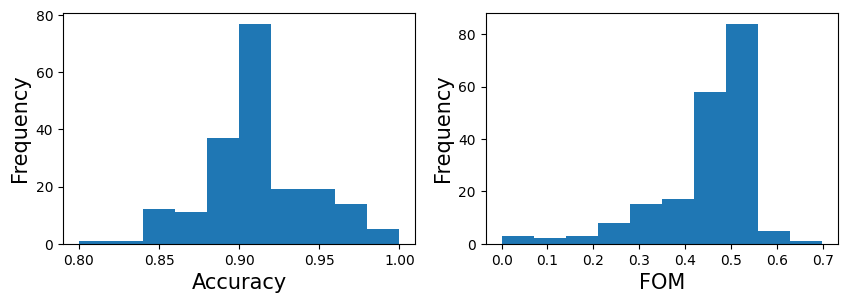

In [ ]:
model_name = "SIVE_13MAR2025_HED_ImageNet_True_wBCE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

backbone = hed.EfficientNetBackbone(in_channels=4)
model = hed.HED(backbone=backbone, out_channels=1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)

[0. 1.]


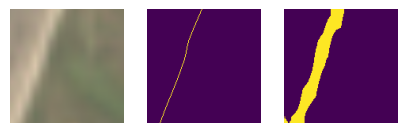

In [ ]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

# HED

Using device: mps

196
accuracy: 88.0097
precision: 4.6612
recall: 97.5202
f1: 8.8723
iou: nan
fom: 38.0964


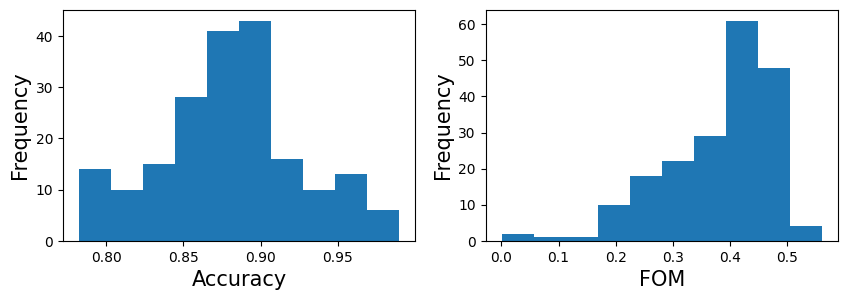

In [ ]:
model_name = "SIVE_01MAR2025_HED_wBCE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

backbone = hed.SimpleCNNBackbone(in_channels=4)
model = hed.HED(backbone=backbone, out_channels=1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)

[0.]


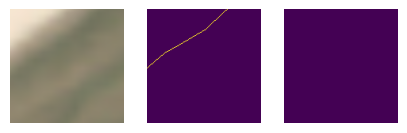

In [ ]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

# UNET

In [ ]:
model_name = "SIVE_30APR2025_UNET_DICE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = unet.U_Net(4, 1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [ ]:
targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

196


[0.]


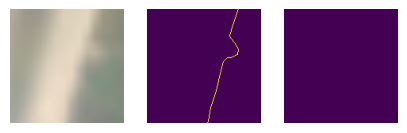

In [ ]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

accuracy: 98.5036
precision: 14.3917
recall: 40.3662
f1: 20.2995
iou: nan
fom: 63.5915


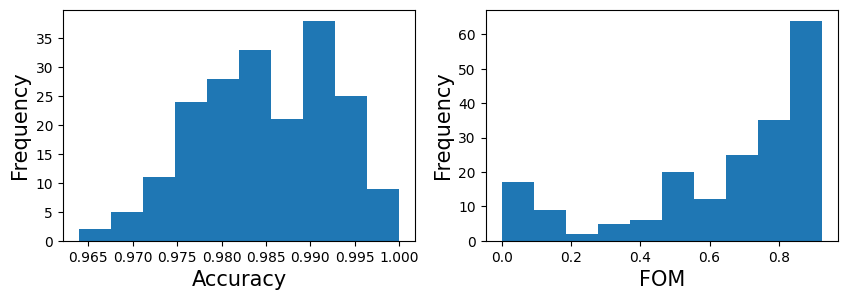

In [ ]:
importlib.reload(eval)
test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)